# Time Series Anomaly Detection Using Keras

## Install and Import Dependencies

In [4]:
pip install plotly

     |████████████████████████████████| 13.2 MB 1.5 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=6c018a86f416a38fa84c68e0f681455a26d7d39d9f40a39590abc5fc507b22ed
  Stored in directory: /Users/maxmohammadi/Library/Caches/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style="whitegrid", palette="muted")
rcParams["figure.figsize"] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

## Load and Inspect ArcSim Telemetry

In [318]:
df = pd.read_csv("LongitudeAnomalies.csv", parse_dates=["datetime"])
df.head()

,datetime,updated longitude
0,2021-03-29 00:00:00,-67.761781
1,2021-03-29 00:01:00,-67.073270
2,2021-03-29 00:02:00,-66.397754
3,2021-03-29 00:03:00,-65.734191
4,2021-03-29 00:04:00,-65.081570


In [319]:
df.shape

(201, 2)

In [320]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df["datetime"], y=df["updated longitude"], mode="lines", name="LongitudeAnomalies.csv"))
fig.update_layout(showlegend=True)
fig.show()

## Data Preprocessing

In [302]:
# 80% of the data for training (past events)
# 20% used for testing (new events)
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train = df.iloc[0:train_size]
test = df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [258]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[["close"]])

train["close"] = scaler.transform(train[["close"]])
test["close"] = scaler.transform(test[["close"]])

## Create Training and Test Splits

In [259]:
def create_sequences(x, y, time_steps=1):
    x_list, y_list = [], []
    
    for i in range(len(x) - time_steps):
        x_list.append(x.iloc[i:(i+time_steps)].values)
        y_list.append(y.iloc[i+time_steps])
    
    return np.array(x_list), np.array(y_list)

In [261]:
time_steps = 30 #hours

x_train, y_train = create_sequences(train[["close"]], train["close"], time_steps)
x_test, y_test = create_sequences(test[["close"]], test["close"], time_steps)


In [262]:
x_train.shape

(6523, 30, 1)

## Build an LSTM Autoencoder

In [263]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers  import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [264]:
# Train the autoencoder on normal data that does not contain any anomalies

timesteps = x_train.shape[1]
num_features = x_train.shape[2]

In [237]:
# model = Sequential()
# model.add(LSTM(
#     units=64,
#     input_shape=(x_train.shape[1], x_train.shape[2])
# ))
# model.add(Dropout(rate=0.2))
# model.add(RepeatVector(n=x_train.shape[1]))
# model.add(LSTM(units=64, return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(TimeDistributed(Dense(units=x_train.shape[2])))
# model.compile(loss='mae', optimizer='adam')


In [265]:
model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
])

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 30, 128)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_26 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_______________________________________________

## Train the LSTM Autoencoder 

In [266]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")
history = model.fit(
    x_train, 
    y_train, 
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
184/184 [==============================] - 6s 34ms/step - loss: 0.1428 - val_loss: 0.1469
Epoch 2/100
184/184 [==============================] - 6s 31ms/step - loss: 0.1104 - val_loss: 0.1322
Epoch 3/100
184/184 [==============================] - 7s 36ms/step - loss: 0.1003 - val_loss: 0.0491
Epoch 4/100
184/184 [==============================] - 6s 31ms/step - loss: 0.0816 - val_loss: 0.0531
Epoch 5/100
184/184 [==============================] - 6s 30ms/step - loss: 0.0775 - val_loss: 0.0552
Epoch 6/100
184/184 [==============================] - 6s 31ms/step - loss: 0.0780 - val_loss: 0.0335
Epoch 7/100
184/184 [==============================] - 6s 31ms/step - loss: 0.0740 - val_loss: 0.1169
Epoch 8/100
184/184 [==============================] - 6s 31ms/step - loss: 0.0803 - val_loss: 0.0383
Epoch 9/100
184/184 [==============================] - 6s 31ms/step - loss: 0.0720 - val_loss: 0.0283
Epoch 10/100
184/184 [==============================] - 6s 31ms/step - loss: 0.073

184/184 [==============================] - 6s 33ms/step - loss: 0.0705 - val_loss: 0.0670
Epoch 81/100
184/184 [==============================] - 6s 32ms/step - loss: 0.0709 - val_loss: 0.0693
Epoch 82/100
184/184 [==============================] - 6s 32ms/step - loss: 0.0712 - val_loss: 0.0673
Epoch 83/100
184/184 [==============================] - 7s 35ms/step - loss: 0.0707 - val_loss: 0.0639
Epoch 84/100
184/184 [==============================] - 7s 37ms/step - loss: 0.0714 - val_loss: 0.0656
Epoch 85/100
184/184 [==============================] - 7s 35ms/step - loss: 0.0710 - val_loss: 0.0677
Epoch 86/100
184/184 [==============================] - 6s 34ms/step - loss: 0.0706 - val_loss: 0.0640
Epoch 87/100
184/184 [==============================] - 6s 33ms/step - loss: 0.0699 - val_loss: 0.0623
Epoch 88/100
184/184 [==============================] - 6s 33ms/step - loss: 0.0705 - val_loss: 0.0642
Epoch 89/100
184/184 [==============================] - 6s 34ms/step - loss: 0.0718 - 

## Plot Metrics and Evaluate the Model

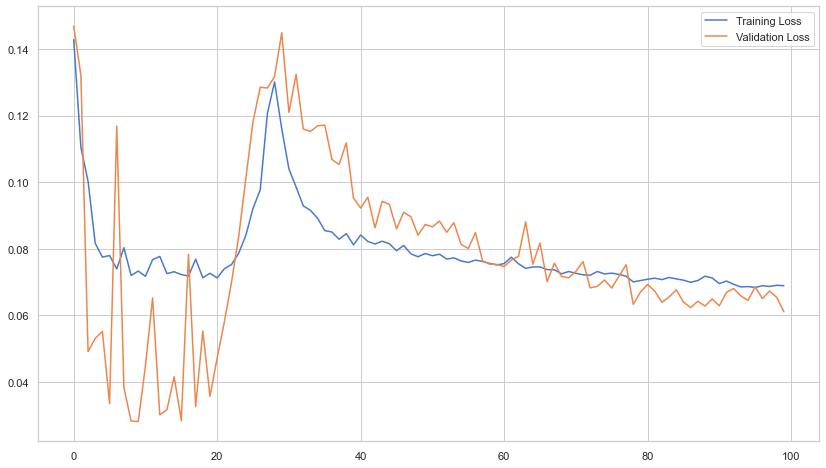

In [267]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend();

In [268]:
# Calculate Mean Absolute Error
x_train_pred = model.predict(x_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(x_train_pred - x_train), axis=1), columns=["Error"])

In [291]:
model.evaluate(x_test, y_test)

51/51 [==============================] - 1s 10ms/step - loss: 1.2107


1.2107328176498413

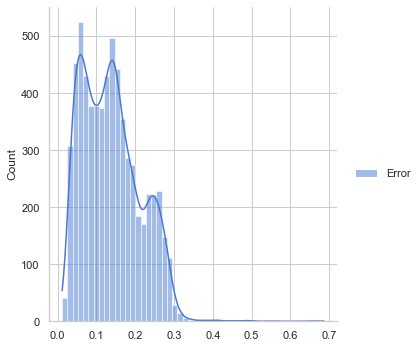

In [270]:
sns.displot(train_mae_loss, bins=50, kde=True)

In [311]:
threshold = 1.4

In [312]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred, x_test), axis=1)

## Detect Anomalies in the Spacecraft Telemetry

In [313]:
test_score_df = pd.DataFrame(index=test[time_steps:].index)
test_score_df["loss"] = test_mae_loss
test_score_df["threshold"] = threshold
test_score_df["anomaly"] = test_score_df.loss > test_score_df.threshold
test_score_df["close"] = test[time_steps:].close

In [314]:
test_score_df.head()

,loss,threshold,anomaly,close
6583,1.127479,1.4,False,1349.96
6584,1.128807,1.4,False,1351.95
6585,1.129644,1.4,False,1342.64
6586,1.121389,1.4,False,1351.77
6587,1.128867,1.4,False,1350.50


In [315]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=test[time_steps:]["date"], 
    y=test_score_df.loss,
    mode="lines",
    name="Test Loss"
))

fig.add_trace(go.Scatter(
    x=test[time_steps:]["date"], 
    y=test_score_df.threshold,
    mode="lines",
    name="Threshold"
))

fig.update_layout(showlegend=True)
fig.show()

In [316]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
7177,1.400147,1.4,True,1962.87
7178,1.401063,1.4,True,1962.61
7179,1.401054,1.4,True,1949.98
7181,1.400255,1.4,True,1957.22
7183,1.400428,1.4,True,1960.23


/Users/maxmohammadi/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



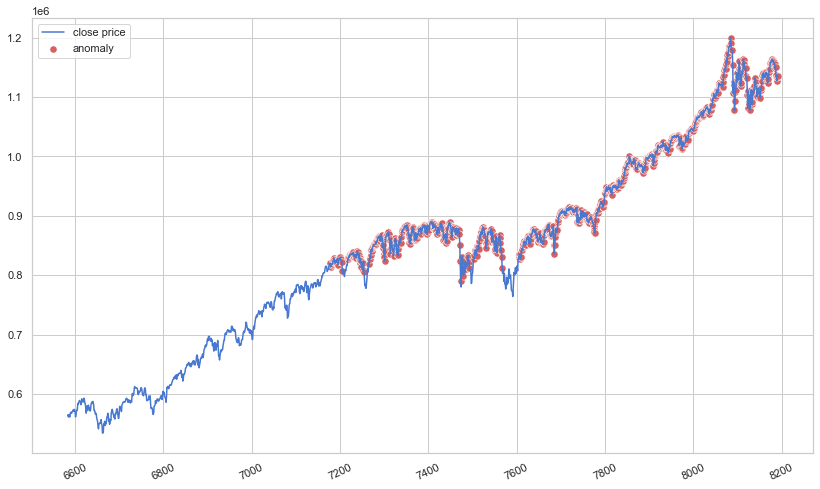

In [317]:
plt.plot(
    test[time_steps:].index,
    scaler.inverse_transform(test[time_steps:].close),
    label="close price"
);

sns.scatterplot(
    anomalies.index,
    scaler.inverse_transform(anomalies.close),
    color=sns.color_palette()[3],
    s=52,
    label="anomaly"
)
plt.xticks(rotation=25)
plt.legend()